In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import os
import logging

logger = logging.getLogger(__name__)
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] \t %(message)s",
    datefmt="%b %d %Y %I:%M%p",
)

os.chdir("../")

In [3]:
from src.utils import *
from src.etl import *
from src.rfm import *
import numpy as np
import matplotlib.pyplot as plt
import PyPDF2

In [4]:
logger.info("test")

Mar 04 2023 11:37PM [INFO] 	 test


In [5]:
# get current directory
os.getcwd()

'/Users/rohitmishra/ml-theory-capstone'

In [6]:
# get all urls to make all datasets
import re

def clean_url(x):
    search = re.findall(r'"(.*?)"', x)
    if search:
        return search[0]
    else:
        return ""

urls = list(filter(lambda x: len(x) > 0, map(clean_url, open("/Users/rohitmishra/ml-theory-capstone/src/urls.txt", "r").readlines())))


In [7]:

# Pdf dataset
pdf_fp = "/Users/rohitmishra/Desktop/1984.pdf"
#pdf_fp = "/Users/rohitmishra/Desktop/Interview Frameworks & Tips from a Google PM (Berkeley).pdf"
pdf_tokenized = pdf_tokenizer(pdf_fp,contextsize=256)


Mar 04 2023 11:39PM [INFO] 	 Unknown characters: {42, 43, 61, 24, 91, 93}


In [8]:
pdf_tokenized.shape

(2364, 256, 50)

In [ ]:
make_all_datasets(urls)

In [12]:
corpus = generate_corpus()

Feb 28 2023 05:43PM [INFO] 	 Unknown characters: {64, 34, 37, 39, 42, 47, 91, 93}
Feb 28 2023 05:43PM [INFO] 	 Unknown characters: {91, 93}
Feb 28 2023 05:43PM [INFO] 	 Unknown characters: {91, 93}
Feb 28 2023 05:43PM [INFO] 	 Unknown characters: {91, 93}
Feb 28 2023 05:43PM [INFO] 	 Unknown characters: {91, 93}
Feb 28 2023 05:43PM [INFO] 	 Unknown characters: {39, 42, 91, 60, 93}
Feb 28 2023 05:43PM [INFO] 	 Unknown characters: {34, 91, 93, 39}


In [9]:
vocab = build_vocab()

In [10]:
reverse_vocab = {i: v for v, i in vocab.items()}

In [11]:
def decode(X):
    """Decodes a (N, context_size, vocab_size) array of one-hot vectors into a list of words.)"""
    return [[reverse_vocab[np.argmax(x)] for x in sentence] for sentence in X]

In [12]:
#decoded_corpus = decode(corpus)
decoded_corpus = decode(pdf_tokenized)
#pdf_decoded_corpus = decode(pdf_tokenized)

In [13]:
#corpus = corpus.reshape(-1, len(vocab)*64)
corpus = pdf_tokenized.reshape(-1, len(vocab)*64)

In [14]:
corpus.shape

(9456, 3200)

## Baseline: Bigrams/Trigrams

In [34]:
from nltk.util import bigrams, trigrams, pad_sequence
from nltk.lm.preprocessing import padded_everygram_pipeline, flatten
from nltk.lm import MLE

In [35]:
CONTEXT_SIZE = 64
TEST_SPLIT = 0.2

In [36]:
train_corpus = np.array(decoded_corpus[: int(len(decoded_corpus) * (1 - TEST_SPLIT))])
test_corpus = np.array(decoded_corpus[int(len(decoded_corpus) * (1 - TEST_SPLIT)) :])

In [37]:
len(train_corpus), len(test_corpus)

(1891, 473)

In [38]:
# shop the dataset in 3/4 - 1/4 split. The 3/4 will be used to conditionally generate the 1/4
CONTEXT_SPLIT_SIZE = int(3/4 * CONTEXT_SIZE)
X_train = train_corpus[:, :CONTEXT_SPLIT_SIZE]
y_train = train_corpus[:, CONTEXT_SPLIT_SIZE:]
X_test = test_corpus[:, :CONTEXT_SPLIT_SIZE]
y_test = test_corpus[:, CONTEXT_SPLIT_SIZE:]

In [39]:
np.where(X_train.flatten() == "<UNK>")[0].shape

(99,)

In [40]:
# get ngrams
ngrams = []
for sent in X_train:
    ngrams.append(list(bigrams(sent)))


In [41]:
lm = MLE(3)
lm.fit(ngrams, vocab)

In [42]:
X_train[:10]

array([['d', 'o', 'w', 'n', 'l', 'o', 'a', 'd', ' ', 'f', 'r', 'e', 'e',
        ' ', 'e', 'b', 'o', 'o', 'k', 's', ' ', 'o', 'f', ' ', 'c', 'l',
        'a', 's', 's', 'i', 'c', ' ', 'l', 'i', 't', 'e', 'r', 'a', 't',
        'u', 'r', 'e', ',', ' ', 'b', 'o', 'o', 'k'],
       [' ', 'c', 'l', 'o', 'c', 'k', 's', ' ', 'w', 'e', 'r', 'e', ' ',
        's', 't', 'r', 'i', 'k', ' ', '-', ' ', 'i', 'n', 'g', ' ', 't',
        'h', 'i', 'r', 't', 'e', 'e', 'n', '.', ' ', 'w', 'i', 'n', 's',
        't', 'o', 'n', ' ', 's', 'm', 'i', 't', 'h'],
       ['-', ' ', 'i', 'n', 'g', ' ', 'a', 'l', 'o', 'n', 'g', ' ', 'w',
        'i', 't', 'h', ' ', 'h', 'i', 'm', '.', ' ', 't', 'h', 'e', ' ',
        'h', 'a', 'l', 'l', 'w', 'a', 'y', ' ', 's', 'm', 'e', 'l', 't',
        ' ', 'o', 'f', ' ', 'b', 'o', 'i', 'l', 'e'],
       ['f', ' ', ' ', 'a', 'b', 'o', 'u', 't', ' ', 'f', 'o', 'r', 't',
        'y', '-', 'f', 'i', 'v', 'e', ',', ' ', 'w', 'i', 't', 'h', ' ',
        'a', ' ', 'h', 'e', 'a', 'v

In [43]:
def generate_text(lm, X_test, length=CONTEXT_SIZE-CONTEXT_SPLIT_SIZE):
    # generate text
    text = []
    for sent in X_test:
        text.append(lm.generate(length, text_seed=sent))
    return text

In [44]:
y_test.shape

(473, 208)

In [45]:
y_test_pred = np.array(generate_text(lm, X_test))

In [46]:
"".join(y_test[0]), "".join(y_test_pred[0])

('y case soon perishes: only in the mind of the party,  which is collective and immortal. whatever the party holds  to be the truth, is truth. it is impossible to see reality except  by looking through the eyes',
 'ctes<UNK>w<UNK>ieand<UNK>ty<UNK>')

In [47]:
lm.vocab.unk_label

'<UNK>'

In [48]:
class Vocab():
    def __init__(self, vals):
        self._dict = {v: i for i, v in enumerate(vals)}
        self._dict['<UNK>'] = len(self._dict)
        self.rev = {i: v for v, i in self._dict.items()}
    
    def __getitem__(self, key):
        if key in self._dict:
            return self._dict[key]
        else:
            return self._dict['<UNK>']
    
    def __len__(self):
        return len(self._dict)
    
    def __iter__(self):
        return iter(self._dict)
    
    def __contains__(self, key):
        return key in self._dict
    
    def __repr__(self):
        return f"{self.__class__.__name__}({self._dict})"
    
    def decode(self, idx):
        return self.rev[idx]

In [49]:
train_vocab = Vocab(list(sorted(lm.vocab.counts.keys())))
train_vocab

Vocab({' ': 0, '!': 1, '&': 2, '(': 3, ')': 4, ',': 5, '-': 6, '.': 7, '0': 8, '1': 9, '2': 10, '3': 11, '4': 12, '5': 13, '6': 14, '7': 15, '8': 16, '9': 17, ':': 18, ';': 19, '<UNK>': 50, '?': 21, '_': 22, 'a': 23, 'b': 24, 'c': 25, 'd': 26, 'e': 27, 'f': 28, 'g': 29, 'h': 30, 'i': 31, 'j': 32, 'k': 33, 'l': 34, 'm': 35, 'n': 36, 'o': 37, 'p': 38, 'q': 39, 'r': 40, 's': 41, 't': 42, 'u': 43, 'v': 44, 'w': 45, 'x': 46, 'y': 47, 'z': 48, '’': 49})

In [50]:
def encode(sent, vocab=train_vocab):
    return np.array([vocab[w] for w in sent])

def evaluate(y_test, y_test_pred):
    # evaluate
    bleu = []
    perplexity = []
    for i in range(len(y_test)):
        bleu.append(utils.bleu_score([y_test[i]], y_test_pred[i], n=2))
        perplexity.append(utils.perplexity(encode(y_test_pred[i])))
    return { "bleu2": np.mean(bleu), "perplexity": np.mean(perplexity) }

In [51]:
list(map(lambda x: "".join(x), y_test_pred))

['ctes<UNK>w<UNK>ieand<UNK>ty<UNK>',
 'howars<UNK>tesose<UNK>in',
 'ery<UNK>lace<UNK>ine<UNK>fre',
 'm,<UNK>buly<UNK>lo<UNK>ard<UNK>o',
 'urofeatesurthe<UNK>t',
 'bl,<UNK>obor<UNK>lid,<UNK>to',
 'onoely<UNK>ematomsu<UNK>',
 '<UNK><UNK>ar,<UNK>con<UNK>ors<UNK><UNK>e',
 'ememt<UNK>clo<UNK>scerec',
 'soug.<UNK>wn<UNK><UNK>t<UNK>k<UNK>t<UNK>',
 'ind<UNK>theavemicons',
 'nghi<UNK>n<UNK>hireld<UNK>tw',
 'gnthedisthal<UNK>ofo',
 'pupreng<UNK>inanerar',
 'o<UNK>was<UNK>chedove<UNK>ry',
 '<UNK>wop<UNK>g<UNK>thebuthit',
 'nemamiond.<UNK>fon<UNK>i',
 'mma<UNK>m<UNK>eens?’bed<UNK>',
 '<UNK>er<UNK>wick<UNK>an<UNK>of<UNK>c',
 'whitompes<UNK><UNK>braie',
 'lerer<UNK>pe<UNK>in<UNK><UNK>we<UNK>',
 'nided<UNK>he<UNK>tomio<UNK>o',
 'ara.ct<UNK>s<UNK>henge<UNK>s',
 'at<UNK>med<UNK>sha,<UNK><UNK><UNK>ve',
 '<UNK><UNK>me<UNK>at<UNK>sasea<UNK>pr',
 'ce<UNK>f<UNK>y<UNK>whan<UNK><UNK>ain',
 'edekecon<UNK>o<UNK>here<UNK>',
 'wacowame<UNK>he<UNK>wher',
 'et<UNK>ustonde<UNK>toru<UNK>',
 'out<UNK>ben<UNK>endofino'

In [52]:
evaluate(y_test, y_test_pred)

/Users/rohitmishra/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


{'bleu2': 2.9938302420463266e-06, 'perplexity': 15.330075610564377}

## Laplacian Kernel

In [53]:
# replace each token with its index in the vocab
X_train_enc = np.array([encode(sent) for sent in X_train])
y_train_enc = np.array([encode(sent) for sent in y_train])
X_test_enc = np.array([encode(sent) for sent in X_test])
y_test_enc = np.array([encode(sent) for sent in y_test])

In [54]:
train_vocab = vocab

In [55]:
len(vocab)

50

In [56]:
corpus.shape

(9456, 3200)

In [57]:
SUBSET_SIZE = 1000

In [58]:
# randomly subset data
subset = np.random.choice(corpus.shape[0], SUBSET_SIZE, replace=True)

subset_corpus = corpus[subset]

In [59]:
train_data = subset_corpus[: int(len(subset_corpus) * (1 - TEST_SPLIT))]
test_data = subset_corpus[int(len(subset_corpus) * (1 - TEST_SPLIT)) :]

train_data.shape, test_data.shape

((800, 3200), (200, 3200))

In [60]:
KERNEL_SPLIT_SIZE = int(3/4 * CONTEXT_SIZE)

X_train_enc = train_data[:, :CONTEXT_SPLIT_SIZE*len(vocab)].astype("float32")
y_train_enc = train_data[:, CONTEXT_SPLIT_SIZE*len(vocab):].astype("float32")
X_test_enc = test_data[:, :CONTEXT_SPLIT_SIZE*len(vocab)].astype("float32")
y_test_enc = test_data[:, CONTEXT_SPLIT_SIZE*len(vocab):].astype("float32")

X_train_enc.shape, y_train_enc.shape, X_test_enc.shape, y_test_enc.shape

((800, 2400), (800, 800), (200, 2400), (200, 800))

In [61]:
from functools import partial

In [62]:
next_char_train = y_train_enc[:, :len(train_vocab)]
next_char_test = y_test_enc[:, :len(train_vocab)]

In [63]:
# train a laplace kernel
lam = 1e-3
kernel = partial(utils.K_laplace_mat, gamma=0.001)

K = kernel(X_train_enc, X_train_enc)
alpha_hat = np.linalg.solve(K + lam * np.eye(K.shape[0]), next_char_train)

In [64]:
yhat = kernel(X_test_enc, X_train_enc) @ alpha_hat
yhat

array([[ 4.17085979e-01,  2.64666643e-02, -8.59442666e-02, ...,
         0.00000000e+00,  7.42433053e-02,  0.00000000e+00],
       [ 4.88589019e-01,  2.81151749e-01, -1.41449429e-01, ...,
         0.00000000e+00,  5.24901296e-03,  0.00000000e+00],
       [ 3.18033425e-01, -3.29531721e-01,  1.36450800e-01, ...,
         0.00000000e+00, -2.22566519e-02,  0.00000000e+00],
       ...,
       [ 1.13728264e+00, -1.17484132e-02,  1.53907029e-01, ...,
         0.00000000e+00, -8.45348174e-02,  0.00000000e+00],
       [ 9.51522338e-01,  5.91074997e-03, -5.65453005e-03, ...,
         0.00000000e+00, -1.55873106e-03,  0.00000000e+00],
       [ 2.00641228e-02,  1.89649454e-03, -3.67651021e-04, ...,
         0.00000000e+00,  2.19551038e-04,  0.00000000e+00]])

In [67]:
(next_char_test.argmax(axis=1) == yhat.argmax(axis=1)).mean()

0.23

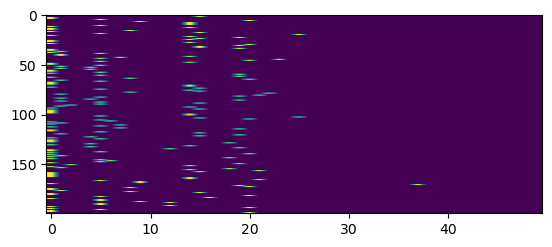

In [68]:
max_index = np.argmax(yhat, axis=1)
yhat[np.arange(yhat.shape[0]), max_index] = 1
yhat[yhat != 1] = 0
plt.imshow(yhat, aspect=0.1)

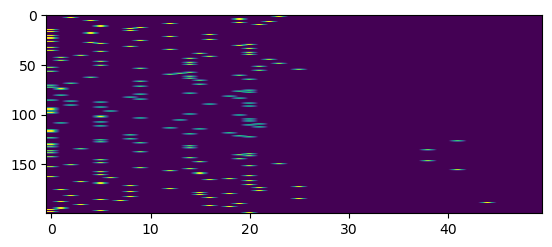

In [69]:
# plot next_char_train, with a good aspect ratio
plt.imshow(next_char_test, aspect=0.1)

In [70]:
yhat_train = kernel(X_train_enc, X_train_enc) @ alpha_hat

(next_char_train.argmax(axis=1) == yhat_train.argmax(axis=1)).mean()

0.9975

In [71]:
def generate_text_kernel(kernel, alpha_hat, X, z, length=16):
    text = []
    for i in range(length):
        yhat = kernel(X, z) @ alpha_hat
        # decode the text
        text.append([reverse_vocab[y] for y in np.argmax(yhat, axis=1)])
        # move the window forward
        X = np.concatenate([X[:, len(train_vocab):], yhat], axis=1)
    
    transpose = list(zip(*text))
    return transpose

In [72]:
generated_test = generate_text_kernel(kernel, alpha_hat, X_test_enc, X_train_enc, length=CONTEXT_SIZE-CONTEXT_SPLIT_SIZE)

In [73]:
list(map(lambda x: "".join(x), generated_test))

[' eoe ott s haseo',
 'sn e na itet nig',
 'ot eohi te t lls',
 '  u htn sare otr',
 ' he onhnohstaoto',
 'e i  t ee ily  h',
 't aneeti  o re a',
 'ie e raaou  hiit',
 'n teaee nesiteha',
 'neei is ois ooto',
 'nln redlhs dhhe ',
 'egsst   s nsedt ',
 ' sstd s cane cis',
 'nt iee  ssnn dat',
 '  hnse n rot wt ',
 ' aeloos r eos oo',
 'heai to   ohn se',
 ' neeenst os siie',
 'o seteos ge inia',
 'etosl e tnno    ',
 'y llta riaeu  eo',
 '  os  te enstae ',
 'ncu anorhs s he ',
 'snd  inencis   o',
 'oe htoht eh  es ',
 'noe  aoerenn one',
 ' aneonss sed a o',
 ' n n   ttneoore ',
 'ne  erultne in n',
 ' t notmnsienlo d',
 't o  enuty crh  ',
 'sc o msear  tlee',
 'o t eo edo  oni ',
 'oauet e cioer u ',
 'sooe loutws e os',
 ' oeisbreg  s oe ',
 ' tn te tn e  hhe',
 'a  eol eh  rhe s',
 ' u  t too d tn s',
 'e t ee et ot eto',
 'agehaedehhe ue  ',
 'a  eenn.  sessdo',
 'nlonn hts  eanan',
 'g hosso t heye a',
 'eey tehe ws os, ',
 'wo  naiienr on a',
 't eisedh n cut s',
 'ehacot rn r

In [74]:
reshaped_y_test = y_test_enc.reshape(-1, CONTEXT_SIZE-CONTEXT_SPLIT_SIZE,len(train_vocab))

y_test_text = ["".join([reverse_vocab[np.argmax(y)] for y in y_test]) for y_test in reshaped_y_test]

len(y_test_text)

200

In [75]:
evaluate(y_test_text, generated_test)

{'bleu2': 0.21281112112194342, 'perplexity': 11.25208752651346}

## RFM

In [76]:
alpha, M, _ = train_rfm(X_train_enc, next_char_train, L=256, T=3)

1


/Users/rohitmishra/ml-theory-capstone/src/utils.py:103: RuntimeWarning: divide by zero encountered in true_divide
  K = K / dist


2
3


In [77]:
y_train_pred = utils.K_M(X_train_enc, X_train_enc, M, L=256) @ alpha

In [78]:
utils.mse(y_train_pred, next_char_train)


0.0009576066911778826

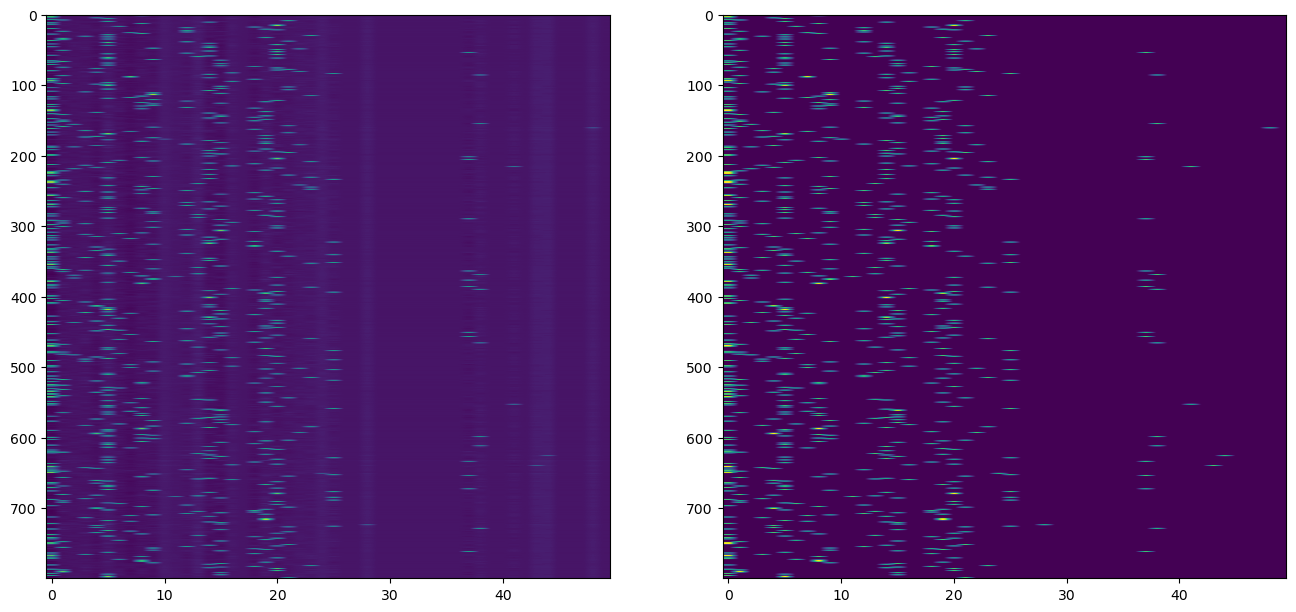

In [79]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 9))
ar = (y_train_pred.shape[1]/y_train_pred.shape[0])
ax[0].imshow(utils.softmax(y_train_pred, axis=1), aspect=ar)
ax[1].imshow(next_char_train, aspect=ar)

In [80]:
y_test_pred = utils.K_M(X_test_enc, X_train_enc, M, L=256) @ alpha

In [81]:
utils.mse(y_test_pred, next_char_test)

0.01964755655838924

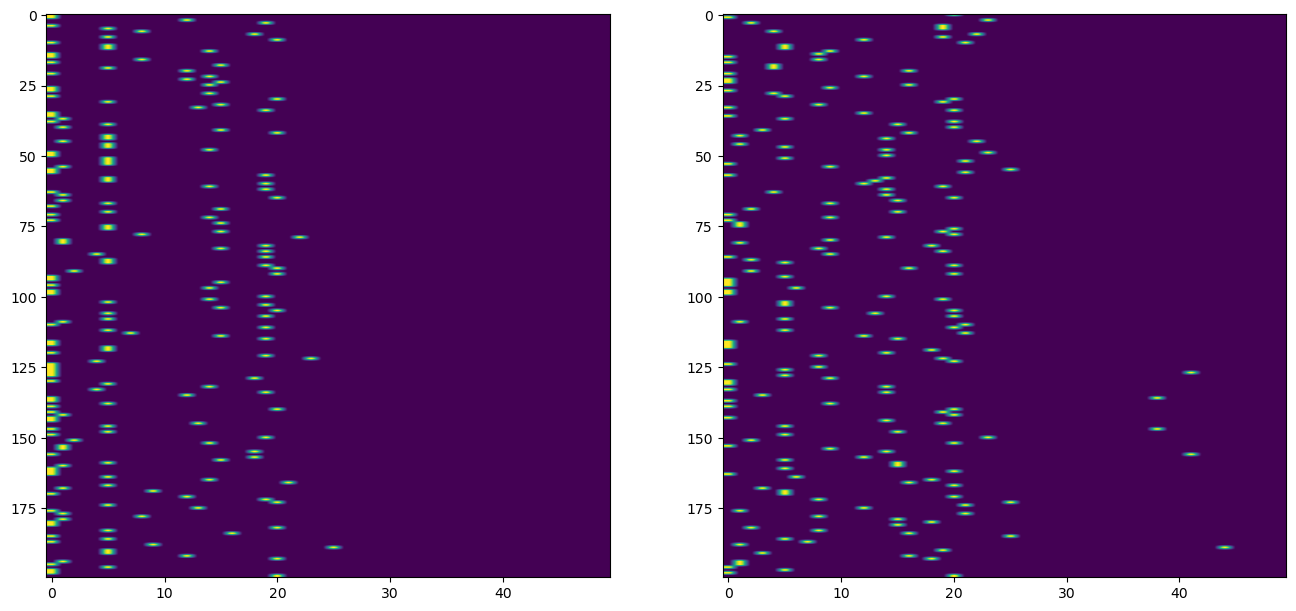

In [82]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 9))
ar = (y_test_pred.shape[1]/y_test_pred.shape[0])
y_test_argmax_ohc = np.eye(len(train_vocab))[y_test_pred.argmax(axis=1)]
ax[0].imshow(y_test_argmax_ohc, aspect=ar)
ax[1].imshow(next_char_test, aspect=ar)

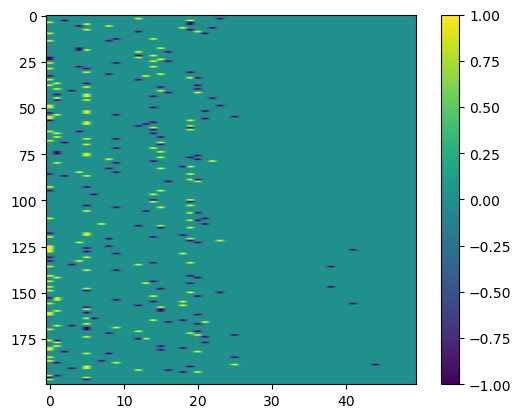

In [83]:
plt.imshow(y_test_argmax_ohc - next_char_test, aspect=ar)
plt.colorbar()

In [84]:
from functools import partial

In [88]:
kernel_rfm = partial(utils.K_M, M=M, L=256)

gen_test_rfm = generate_text_kernel(kernel_rfm, alpha, X_test_enc, X_train_enc, length=CONTEXT_SIZE-CONTEXT_SPLIT_SIZE)

In [89]:
evaluate(y_test_text, gen_test_rfm)

{'bleu2': 0.21401777033829672, 'perplexity': 10.797570239279766}

In [90]:
import random


list(map(lambda x: "".join(x), gen_test_rfm))#[random.randint(0,len(gen_test_rfm))]

[' e iton ysse seo',
 ' ire na m eneyad',
 'l  eoni te   als',
 's soeeneoa e aee',
 ' he tnsc he a sn',
 'e n.  neetale  h',
 'h aaeete co es m',
 're e ra ou  oe t',
 'e  euee nesh ame',
 'tee  hseais ool ',
 ' rt e al eethhd ',
 'essit yes  iee  ',
 'eilcd s  aeyeeis',
 'nt ieel ssha dat',
 '  anee a  ot  oa',
 '  e yos a  on oo',
 'he im o s  h  se',
 ' teeen t os diye',
 'o  eee s go enel',
 'et,re e enno  l ',
 'l reta regee  eo',
 '  ge  teeen dme ',
 'n et earc  doh  ',
 'lndd i enci s   ',
 'oe h iyt ee  ed ',
 'non  t eresn ane',
 ' anean e  edcpao',
 ' t sy  tt eonre ',
 'ne  e d  neess n',
 ' tune mns in a e',
 't e u ee y t e s',
 'et a moeur  el e',
 'o t eomsdo  o  a',
 'madet e ei,en e ',
 'sdoe lol to e so',
 ' oeminrel ds ce ',
 ' tt eystioe  he ',
 'a  eot eho el ci',
 ' i en tom   uy s',
 'e e ee el oe eey',
 'an mee onae   ec',
 'oh senn,  ees do',
 't al  hec  eo mn',
 'e atsso  n eye a',
 'ee .u e dss rs  ',
 'aa eyaseeer mol ',
 'e eireth eesua  ',
 'eh coe en e

In [91]:
# get train and test accuracy
train_acc = (next_char_train.argmax(axis=1) == y_train_pred.argmax(axis=1)).mean()
test_acc = (next_char_test.argmax(axis=1) == y_test_pred.argmax(axis=1)).mean()

print(f"Train accuracy: {train_acc:.2f}")
print(f"Test accuracy: {test_acc:.2f}")

Train accuracy: 1.00
Test accuracy: 0.24


## Bigram Implementation

In [92]:
import random

class NgramModel:
    def __init__(self, n):
        self.n = n
        self.ngrams = {}
        self.total_count = 0

    def update(self, text):
        for i in range(len(text) - self.n):
            ngram = text[i:i+self.n]
            next_char = text[i+self.n]
            if ngram not in self.ngrams:
                self.ngrams[ngram] = {}
            if next_char not in self.ngrams[ngram]:
                self.ngrams[ngram][next_char] = 0
            self.ngrams[ngram][next_char] += 1
            self.total_count += 1

    def predict(self, prefix):
        if prefix not in self.ngrams:
            return random.choice(list(self.ngrams.keys()))[0]
        choices = list(self.ngrams[prefix].items())
        total = sum(count for _, count in choices)
        r = random.uniform(0, total)
        upto = 0
        for choice, count in choices:
            if upto + count >= r:
                return choice
            upto += count
        return choices[-1][0]

    def generate(self, length):
        start = random.choice(list(self.ngrams.keys()))
        text = start
        for i in range(length - self.n):
            prefix = text[-self.n:]
            text += self.predict(prefix)
        return text

In [93]:
pdf_file = open(pdf_fp,"rb")

pdf_reader = PyPDF2.PdfReader(pdf_file)

# Extract text from each page in the PDF file
lines = []

for page in range(len(pdf_reader.pages)):
    page_obj = pdf_reader.pages[page]
    text = page_obj.extract_text()
    lines.extend(text.split('\n'))

# Close the PDF file
pdf_file.close()

In [100]:
# Initialize the model with an n-gram value
model = NgramModel(n=10)

# Update the model with a list of strings

for string in lines:
    model.update(string)

generated_text = []
for i in range(len(y_test_text)):
# Generate text using the model
    generated_text.append(model.generate(16))
    


In [101]:
evaluate(y_test_text, generated_text)

{'bleu2': 0.1863769872900521, 'perplexity': 12.758595614114387}

In [102]:
generated_text

['es, too, the mvp',
 'f minor risks su',
 ' back. But of la',
 'lugged out eertt',
 'd set a pan of w',
 ' the freck -e  e',
 'ehill here and t',
 'nearly a quarter',
 ' in wealth t.i1u',
 'oaring sound wer',
 'ound. A blond-he',
 'd clear. Somewhe',
 'ure he resettled',
 'were deeply redd',
 ' rewriting uihen',
 'rap of some desc',
 'have tried eaays',
 'ive concealed so',
 ' socks or underc',
 'lkily and withou',
 ' he echoed. iae ',
 'of dimpled knees',
 'o attempt was ma',
 'gton for a few m',
 'utes Hate he cou',
 'ak word of this ',
 ' surprised if——’',
 ' One never had e',
 'c dock, confessi',
 'paper into spira',
 'ildren, street b',
 'y she reappeared',
 't know, I’m sure',
 'side it was with',
 'ng-point of your',
 'erable to us tha',
 'But the temptati',
 'loodlit. The squ',
 's, I consider an',
 'st,’ ran the eh ',
 'h one was never ',
 'ow already. but ',
 'he Thought Polic',
 'er than exactitu',
 'volving the de -',
 ' lying on the se',
 't abandon them. ',
 'n. The arit